# Searching Through Hypothesis Space

In [23]:
%matplotlib inline
import numpy as np
import pandas
import sys
from plotnine import *
sys.path.append('..')
from plotting import plot_linear_classifier
from plotting import plot_classifier

## Toy dataset

In [24]:
data = pandas.read_pickle('../data/two_2dgaussians.pkl')

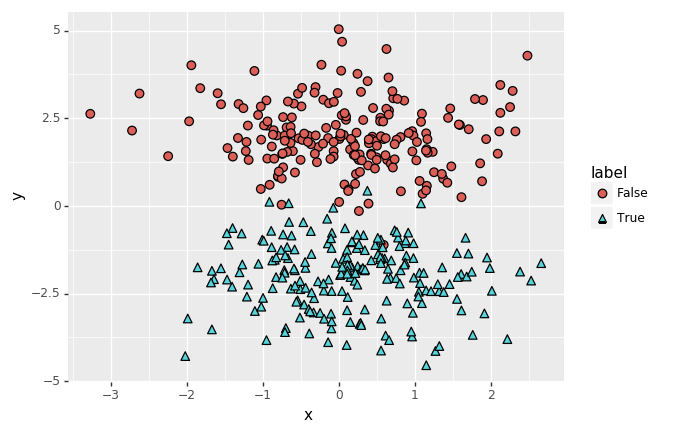

<ggplot: (8731906834226)>

In [25]:
ggplot(data, aes(x='x', y='y', fill='label', shape='label'))+geom_point(size=3)

## Query by commitee (bagging)

In [26]:
def plot_linear_classifier_commitee(sample, data, lgs):
    gp = ggplot(sample, aes(x='x', y='y', fill='label', shape='label'))
    for lg in lgs:
        w0 = lg.intercept_[0]
        w1, w2 = lg.coef_[0]
        def boundary(x):
            return (-w0/w2)+(-w1/w2)*x
        gp = gp+geom_segment(x=data.x.min(),xend=data.x.max(),y=boundary(data.x.min()),yend=boundary(data.x.max()))
        
    return (gp+\
        geom_point(size=3)+\
        geom_point(data, aes(x='x',y='y',color='label')))

In [27]:
def train_commitee(lg, sample):
    for i in range(0,len(lg)):
        s = sample.sample(n = round(0.8*len(sample)), replace=True)
        while len(s.label[s.label==True])==0 or len(s.label[s.label==False])==0:
            s = sample.sample(n = round(0.8*len(sample)), replace=True)
        X = s[['x','y']]
        y = s.label
        lg[i].fit(X,y)

In [28]:
def soft_entropy(lgs, U):
    p = np.zeros(len(U))
    for lg in lgs:
        p = p + lg.predict_proba(U[['x','y']])[:,1]
    p = p/float(len(lgs))
    #entropy = -(p1 * np.log(p1) + p0 * np.log(p0)) -> bei maximimierung reicht aber distanz von 0.5
    return -np.abs(p-0.5)

In [29]:
def aktive_learn(num_samples, initial_sample, data, commitee):
    sample = initial_sample
    labeled = initial_sample.index
    unlabeled = data.index[~data.index.isin(sample.index)]
    for i in range(0,num_samples+1):
        sample = data.loc[labeled]
        X = sample[['x','y']]
        y = sample.label
        train_commitee(commitee, sample)
        U = data.loc[unlabeled]  
        entropy = soft_entropy(lg, U)
        xstar_index = U.index[np.argmax(entropy)]
        labeled = labeled.insert(0,xstar_index)
        unlabeled = unlabeled.drop(xstar_index)
    return sample

In [30]:
from sklearn.linear_model import LogisticRegression
sample = data.sample(10)
C = 5
lg = [LogisticRegression() for i in range(0,C)]

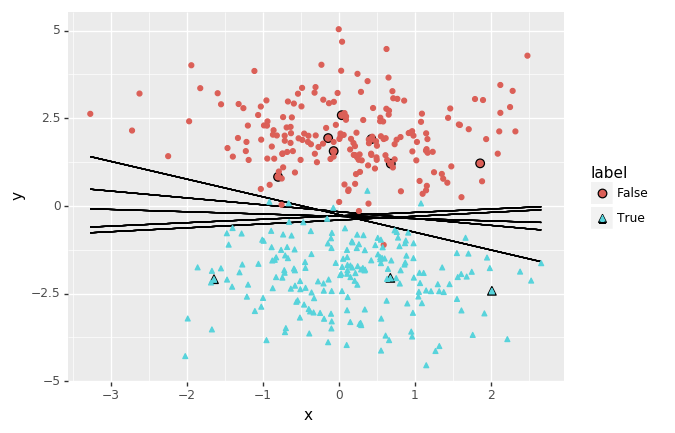

<ggplot: (8731906834254)>

In [31]:
train_commitee(lg, sample)
plot_linear_classifier_commitee(sample,data,lg)

In [32]:
sample = aktive_learn(20, sample, data, lg)

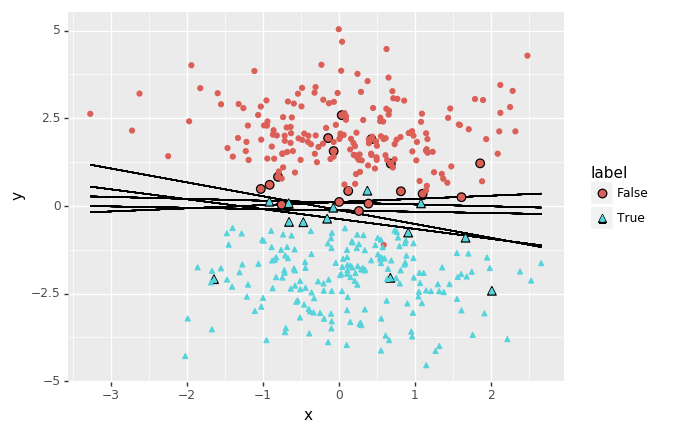

<ggplot: (8731906745471)>

In [33]:
plot_linear_classifier_commitee(sample,data,lg)

## Query by Commitee (with outliers)

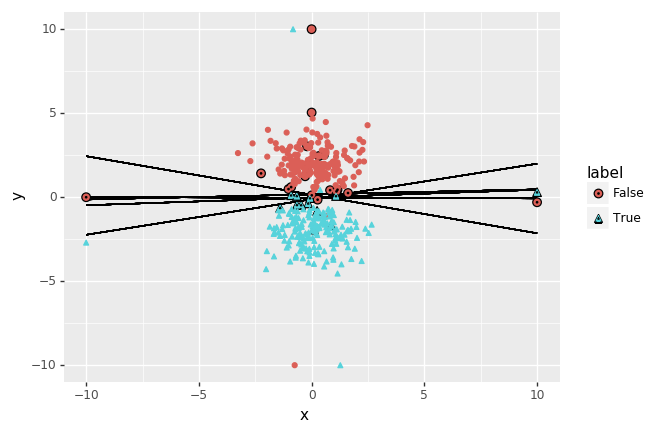

<ggplot: (8731906716911)>

In [34]:
data = pandas.read_pickle('../data/two_2dgaussians_with_outliers.pkl')
initial_sample = data.sample(10)
sample = aktive_learn(20, initial_sample, data, lg)
selected = data.loc[sample.index.difference(initial_sample.index)]
plot_linear_classifier_commitee(sample,data,lg)+geom_point(selected,aes(x='x',y='y'), size=0.1)

## Query by Commitee, skewed data

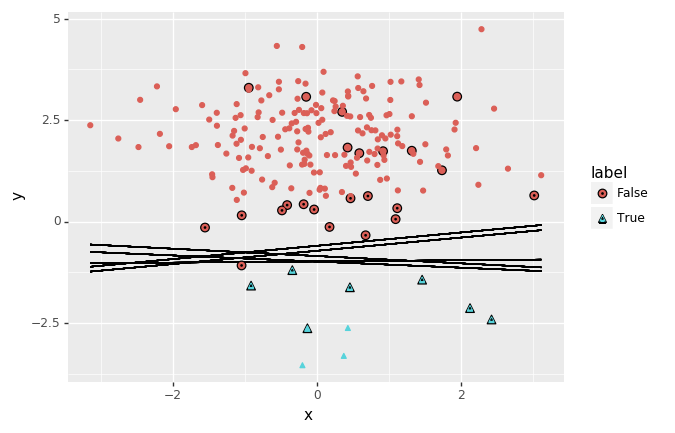

<ggplot: (8731906676179)>

In [35]:
data = pandas.read_pickle('../data/two_2dgaussians_skewed.pkl')
initial_sample = data[data.label==True].sample(1)
initial_sample = initial_sample.append(data.sample(9))
sample = aktive_learn(20, initial_sample, data, lg)
selected = data.loc[sample.index.difference(initial_sample.index)]
plot_linear_classifier_commitee(sample,data,lg)+geom_point(selected,aes(x='x',y='y'), size=0.1)

## Query by Commitee (general vs specific)

In [36]:
def active_learn_gs(num_samples, initial_sample, data, data_bg, model_s, model_g):
    sample = initial_sample
    labeled = sample.index
    unlabeled = data.index[~data.index.isin(sample.index)]
    
    bg_size = len(data_bg)
    specific_bg = pandas.DataFrame({'x':data_bg.x,'y':data_bg.y,'label':np.repeat([False], repeats = bg_size)})
    general_bg = pandas.DataFrame({'x':data_bg.x,'y':data_bg.y,'label':np.repeat([True], repeats = bg_size)})
    for i in range(0,21):
        sample = data.loc[labeled]
        sample_specific = sample.append(specific_bg, ignore_index=True)
        sample_general = sample.append(general_bg, ignore_index=True)
        X_s = sample_specific[['x','y']]
        y_s = sample_specific.label
        X_g = sample_general[['x','y']]
        y_g = sample_general.label
        weights = np.repeat(1.0, len(sample))
        weights = np.append(weights, np.repeat(weight, repeats = bg_size))
        model_s.fit(X_s,y_s,weights)
        model_g.fit(X_g,y_g,weights)

        U = data.loc[unlabeled]  
        entropy = soft_entropy([lg_s, lg_g], U)
        xstar_index = U.index[np.argmax(entropy)]
        labeled = labeled.insert(0,xstar_index)
        unlabeled = unlabeled.drop(xstar_index)
    return sample

### Background data

In [37]:
data = pandas.read_pickle('../data/two_2dgaussians.pkl')
data = pandas.read_pickle('../data/two_2dgaussians_with_outliers.pkl')
data_bg = pandas.read_pickle('../data/two_2dgaussians_bg.pkl')
bg_size = len(data_bg)
specific_bg = pandas.DataFrame({'x':data_bg.x,'y':data_bg.y,'label':np.repeat([False], repeats = bg_size)})
general_bg = pandas.DataFrame({'x':data_bg.x,'y':data_bg.y,'label':np.repeat([True], repeats = bg_size)})

In [38]:
sample = data.sample(10)
sample_specific = sample.append(specific_bg, ignore_index=True)
sample_general = sample.append(general_bg, ignore_index=True)
df_plot = data_bg.copy()
df_plot['label'] = 'Unkown'

In [39]:
lg_s = LogisticRegression()
lg_g = LogisticRegression()

### Initial models

In [40]:
weight = 4.0/bg_size
X_s = sample_specific[['x','y']]
y_s = sample_specific.label
X_g = sample_general[['x','y']]
y_g = sample_general.label
weights = np.repeat(1.0, len(sample))
weights = np.append(weights, np.repeat(weight, repeats = bg_size))

In [41]:
lg_s.fit(X_s,y_s,weights)
lg_g.fit(X_g,y_g,weights)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

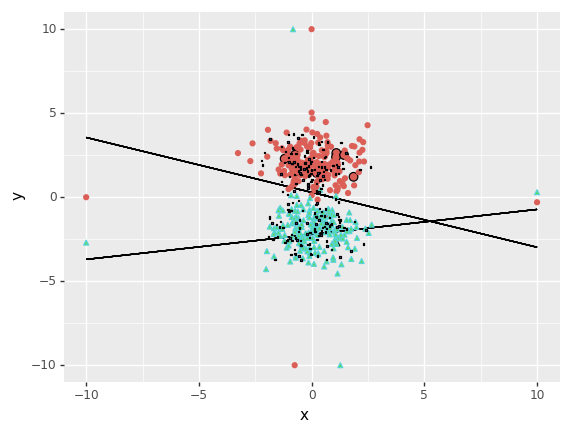

<ggplot: (8731906827980)>

In [42]:
plot_linear_classifier_commitee(sample,data,[lg_s, lg_g])+geom_point(df_plot, size=0.1)+ \
    guides(color=False)+\
    guides(shape=False)+\
    guides(fill=False)

### Active learning

In [43]:
initial_sample = sample
sample = active_learn_gs(20, initial_sample, data, data_bg, lg_s, lg_g)

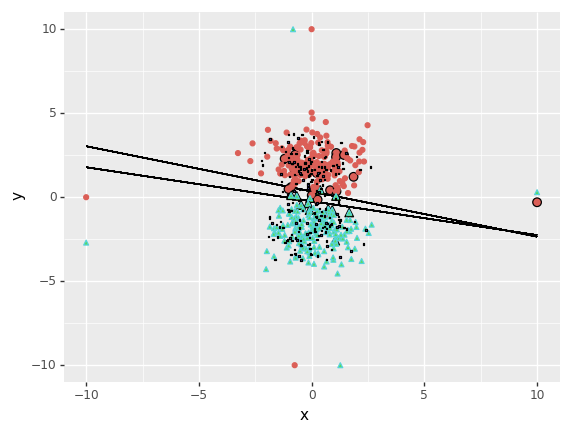

<ggplot: (8731916524636)>

In [44]:
plot_linear_classifier_commitee(sample,data,[lg_s, lg_g])+geom_point(df_plot, size=0.1)+ \
    guides(color=False)+\
    guides(shape=False)+\
    guides(fill=False)

### Query by commitee, skewed data

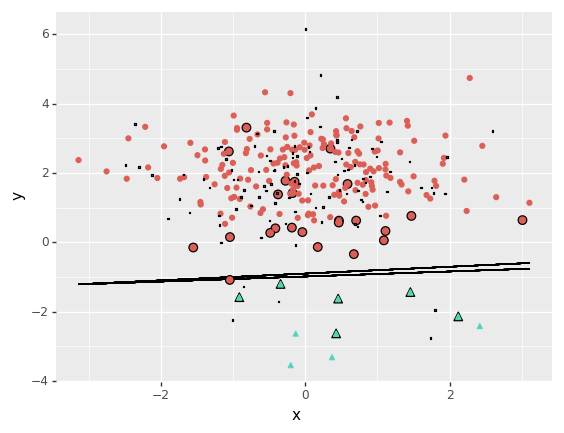

<ggplot: (-9223363304938251148)>

In [45]:
data = pandas.read_pickle('../data/two_2dgaussians_skewed.pkl')
data_bg = pandas.read_pickle('../data/two_2dgaussians_bg_skewed.pkl')
initial_sample = data[data.label==True].sample(1)
initial_sample = initial_sample.append(data.sample(9))
sample = active_learn_gs(20, initial_sample, data, data_bg, lg_s, lg_g)
df_plot = data_bg.copy()
df_plot['label'] = 'Unkown'
plot_linear_classifier_commitee(sample,data,[lg_s, lg_g])+geom_point(df_plot, size=0.1)+ \
    guides(color=False)+\
    guides(shape=False)+\
    guides(fill=False)

## Query by commitee, biased data (general vs specific)

### Toy Dataset

In [46]:
data = pandas.read_pickle('../data/three_2dgaussians.pkl')

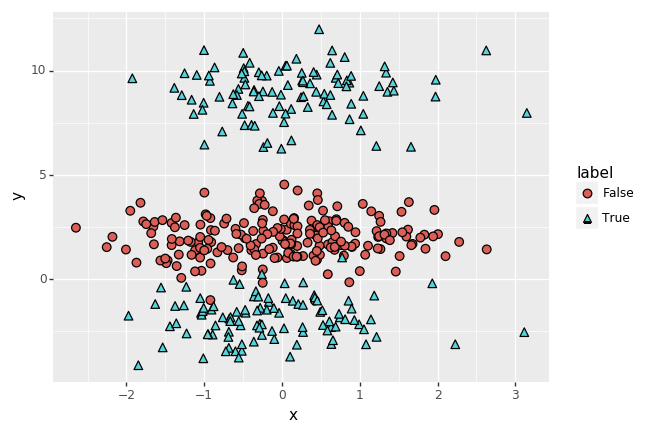

<ggplot: (8731906721649)>

In [47]:
ggplot(data, aes(x='x', y='y', fill='label', shape='label'))+geom_point(size=3)

In [48]:
sample = data[data.y<5].sample(20)
labeled = sample.index
labeled_initial = labeled
unlabeled = data.index[~data.index.isin(sample.index)]

### Background data

In [49]:
data_bg = pandas.read_pickle('../data/three_2dgaussians_bg.pkl')
bg_size = len(data_bg)
specific_bg = pandas.DataFrame({'x':data_bg.x,'y':data_bg.y,'label':np.repeat([False], repeats = bg_size)})
general_bg = pandas.DataFrame({'x':data_bg.x,'y':data_bg.y,'label':np.repeat([True], repeats = bg_size)})

In [50]:
sample_specific = sample.append(specific_bg, ignore_index=True)
sample_general = sample.append(general_bg, ignore_index=True)

### Initial models

In [51]:
from sklearn.ensemble import RandomForestClassifier
rf_g = RandomForestClassifier(n_estimators=100, max_features=2, min_samples_leaf=8)    
rf_s = RandomForestClassifier(n_estimators=100, max_features=2, min_samples_leaf=8)    

In [52]:
weight = 1.0/bg_size
X_s = sample_specific[['x','y']]
y_s = sample_specific.label
X_g = sample_general[['x','y']]
y_g = sample_general.label
weights = np.repeat(1.0, len(sample))
weights = np.append(weights, np.repeat(weight, repeats = bg_size))

In [53]:
rf_s.fit(X_s,y_s,weights)
rf_g.fit(X_g,y_g,weights)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

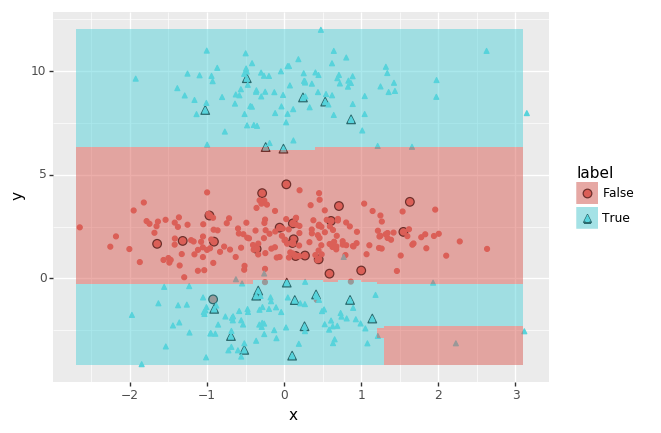

<ggplot: (8731906650274)>

In [58]:
plot_classifier(sample, data, rf_s)

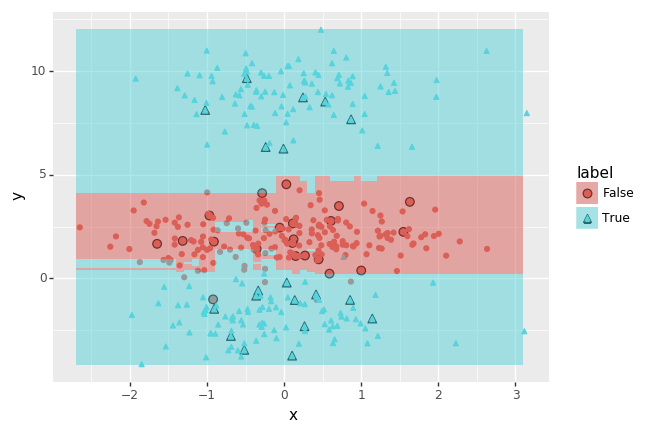

<ggplot: (8731904629680)>

In [59]:
plot_classifier(sample, data, rf_g)

In [60]:
labeled = sample.index
unlabeled = data.index[~data.index.isin(sample.index)]
for i in range(0,21):
    sample = data.loc[labeled]
    sample_specific = sample.append(specific_bg, ignore_index=True)
    sample_general = sample.append(general_bg, ignore_index=True)
    X_s = sample_specific[['x','y']]
    y_s = sample_specific.label
    X_g = sample_general[['x','y']]
    y_g = sample_general.label
    weights = np.repeat(1.0, len(sample))
    weights = np.append(weights, np.repeat(weight, repeats = bg_size))
    rf_s.fit(X_s,y_s,weights)
    rf_g.fit(X_g,y_g,weights)
    
    U = data.loc[unlabeled]  
    entropy = soft_entropy([rf_s, rf_g], U)
    xstar_index = U.index[np.argmax(entropy)]
    labeled = labeled.insert(0,xstar_index)
    unlabeled = unlabeled.drop(xstar_index)

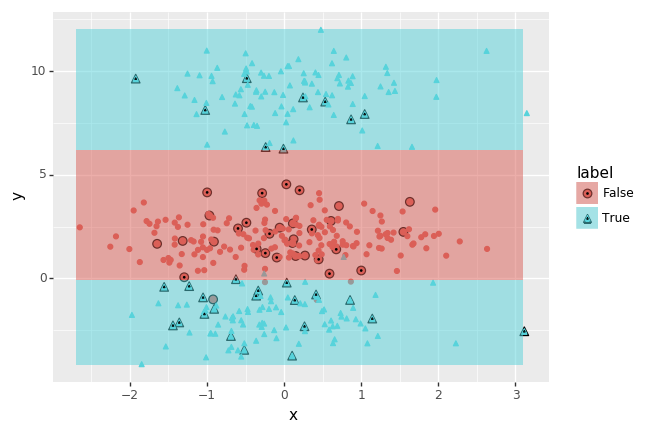

<ggplot: (8731916553897)>

In [61]:
selected = data.loc[sample.index.difference(labeled_initial)]
plot_classifier(sample, data, rf_s)+geom_point(selected,aes(x='x',y='y'), size=0.1)

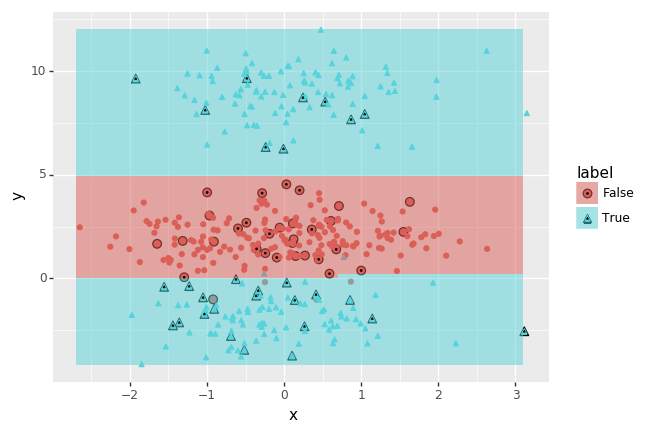

<ggplot: (-9223363304948133835)>

In [62]:
plot_classifier(sample, data, rf_g)+geom_point(selected,aes(x='x',y='y'), size=0.1)

In [63]:
rf = RandomForestClassifier(n_estimators=100, max_features=2)    

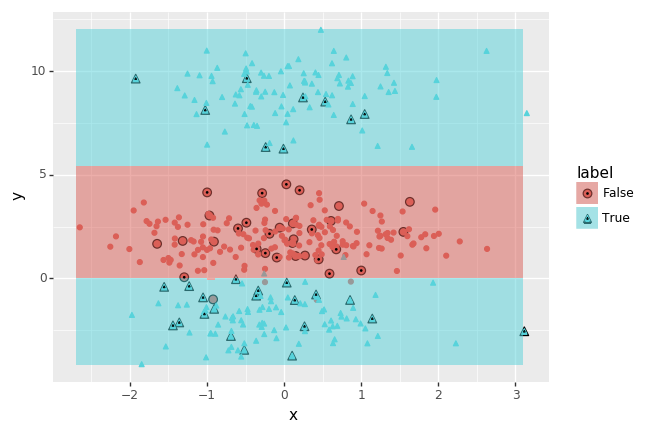

<ggplot: (-9223363304948019996)>

In [64]:
X = sample[['x','y']]
y = sample.label
rf.fit(X,y)
plot_classifier(sample, data, rf)+geom_point(selected,aes(x='x',y='y'), size=0.1)